In [1]:
import torch
import time
import gc
import math
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image

import os
import sys
sys.path.append('../')
from cnn.commons import inc_inference_e2e, full_inference_e2e, adaptive_drilldown
from cnn.vgg16 import VGG16
from cnn.vgg16_inc_v1 import IncrementalVGG16V1

image_file_path = "../cnn/dog_resized.jpg"
interested_logit_index = 208

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
torch.set_num_threads(8)
os.environ['OMP_NUM_THREADS'] = '8'

In [3]:
# torch.cuda.synchronize()
prev_time = time.time()
outputs_full = full_inference_e2e(VGG16, image_file_path, 4, 4, interested_logit_index,
                                  batch_size=128, cuda=True)
torch.cuda.synchronize()
full_inference_time = time.time() - prev_time
print("Full Inference Time: " + str(full_inference_time))

../cnn/commons.py:108: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  orig_image = Variable(loader(orig_image).unsqueeze(0), volatile=True)


Full Inference Time: 12.1174302101


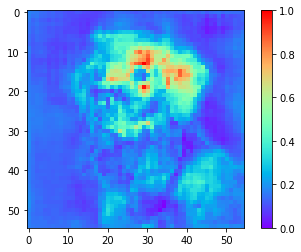

In [4]:
x = outputs_full
xmax, xmin = x.max(), x.min()
x = 1 - (x - xmin)/(xmax - xmin)

outputs_full_final = x
np.savetxt('temp', outputs_full_final)

plt.imshow(x, cmap=plt.cm.rainbow, interpolation='none')
plt.colorbar()

In [5]:
gc.collect()
torch.cuda.empty_cache()

In [6]:
def inc_inference(batch_size, patch_size=4, stride=1, cuda=True):
    logit_index = 208
    
    torch.cuda.synchronize()
    image_patch = torch.FloatTensor(3, patch_size, patch_size).fill_(0)
    if cuda:
        image_patch = image_patch.cuda()
    
    loader = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])
    image = Image.open(image_file_path)
    image = loader(image)
    image = image.unsqueeze(0)
    
    inc_model = IncrementalVGG16V1(image, cuda)
    output_width = int(math.ceil((224.0 - patch_size) / stride))
    
    locations = []
    for i in range(output_width):
        for j in range(output_width):
            locations.append((i*stride,j*stride))
    
    outputs_inc = np.zeros(shape=(output_width, output_width))
    for i in range(0, len(locations), batch_size):
        temp_locations = locations[i:i+batch_size]
        result = inc_model.forward(image, image_patch, temp_locations, patch_size)
        
        for i, (x,y) in enumerate(temp_locations):
            outputs_inc[x/stride,y/stride] = result.cpu().data.numpy()[i, logit_index]
    
    torch.cuda.synchronize()
    x = outputs_inc
    
    xmax, xmin = x.max(), x.min()
    x = 1 - (x - xmin)/(xmax - xmin)
    return x

../cnn/vgg16_inc_v1.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  full_model.forward_materialized(Variable(in_tensor, volatile=True))
../cnn/vgg16_inc_v1.py:131: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  patches = layer(Variable(x, volatile=True)).data
../cnn/vgg16_inc_v1.py:140: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x = Variable(output, volatile=True)


Inference Time: 4.84682393074 MSE: nan


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in divide


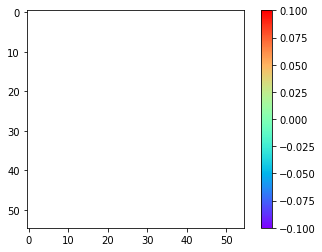

In [7]:
outputs_full_final = np.loadtxt('temp')

prev_time = time.time()
outputs_inc_final = inc_inference(128, patch_size=4, stride=4, cuda=True)
inc_inference_time = time.time()-prev_time
mse = ((outputs_inc_final - outputs_full_final) ** 2).mean(axis=None)

plt.imshow(outputs_inc_final, cmap=plt.cm.rainbow, interpolation='none')
plt.colorbar()
print("Inference Time: " + str(inc_inference_time) + " MSE: " + str(mse))
plt.show()

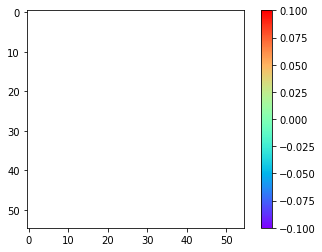

In [8]:
temp = np.abs(np.around(outputs_full_final, decimals=3) - np.around(outputs_inc_final, decimals=3))
plt.imshow(temp, cmap=plt.cm.rainbow, interpolation='none')
plt.colorbar()